# Anubis AI Pipelie

## Installation of needed libraries

- Cloudflare
- Requests (shipped with Python)
- OpenAI (Because we need it to connect to OpenRouter)
- Pillow (To manipulate and understand image files)

In [1]:
!pip install --pre cloudflare -q
!pip install openai -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 20.6 MB/s eta 0:00:00


_Note:_ Pillow, OpenCV, Requests, etc. Are usually installed on Google Colab or similar environments. If you need to install them manually, please take action before running this notebook.

## Getting API Keys from the environemtn

You must set these keys:

- `OPENROUTER_API_KEY`
- `CLOUDFLARE_ACCOUNT_ID`
- `CLOUDFLAFRE_API_TOKEN`

In your "Secrets" section, then using the following commands, you can get them and store them in proper variables.

In [4]:
from google.colab import userdata

OPENROUTER_API_KEY = userdata.get('OPENROUTER_API_KEY')
CLOUDFLARE_ACCOUNT_ID = userdata.get('CLOUDFLARE_ACCOUNT_ID')
CLOUDFLARE_API_TOKEN = userdata.get('CLOUDFLAFRE_API_TOKEN')

## Setting Cloudflare Up

In [5]:
from cloudflare import Cloudflare

client = Cloudflare(api_token=CLOUDFLARE_API_TOKEN)

## Image to Text Function

In [7]:
def img2text(image, prompt):
  '''
    image: Absolute path to an image file
    prompt: A piece of text working as our system prompt
  '''

  image = open(image, 'rb')

  data = client.workers.ai.run(
    "@cf/llava-hf/llava-1.5-7b-hf",
    account_id=CLOUDFLARE_ACCOUNT_ID,
    image=image.read(),
    prompt=prompt,
    max_tokens=2048
)

  return data

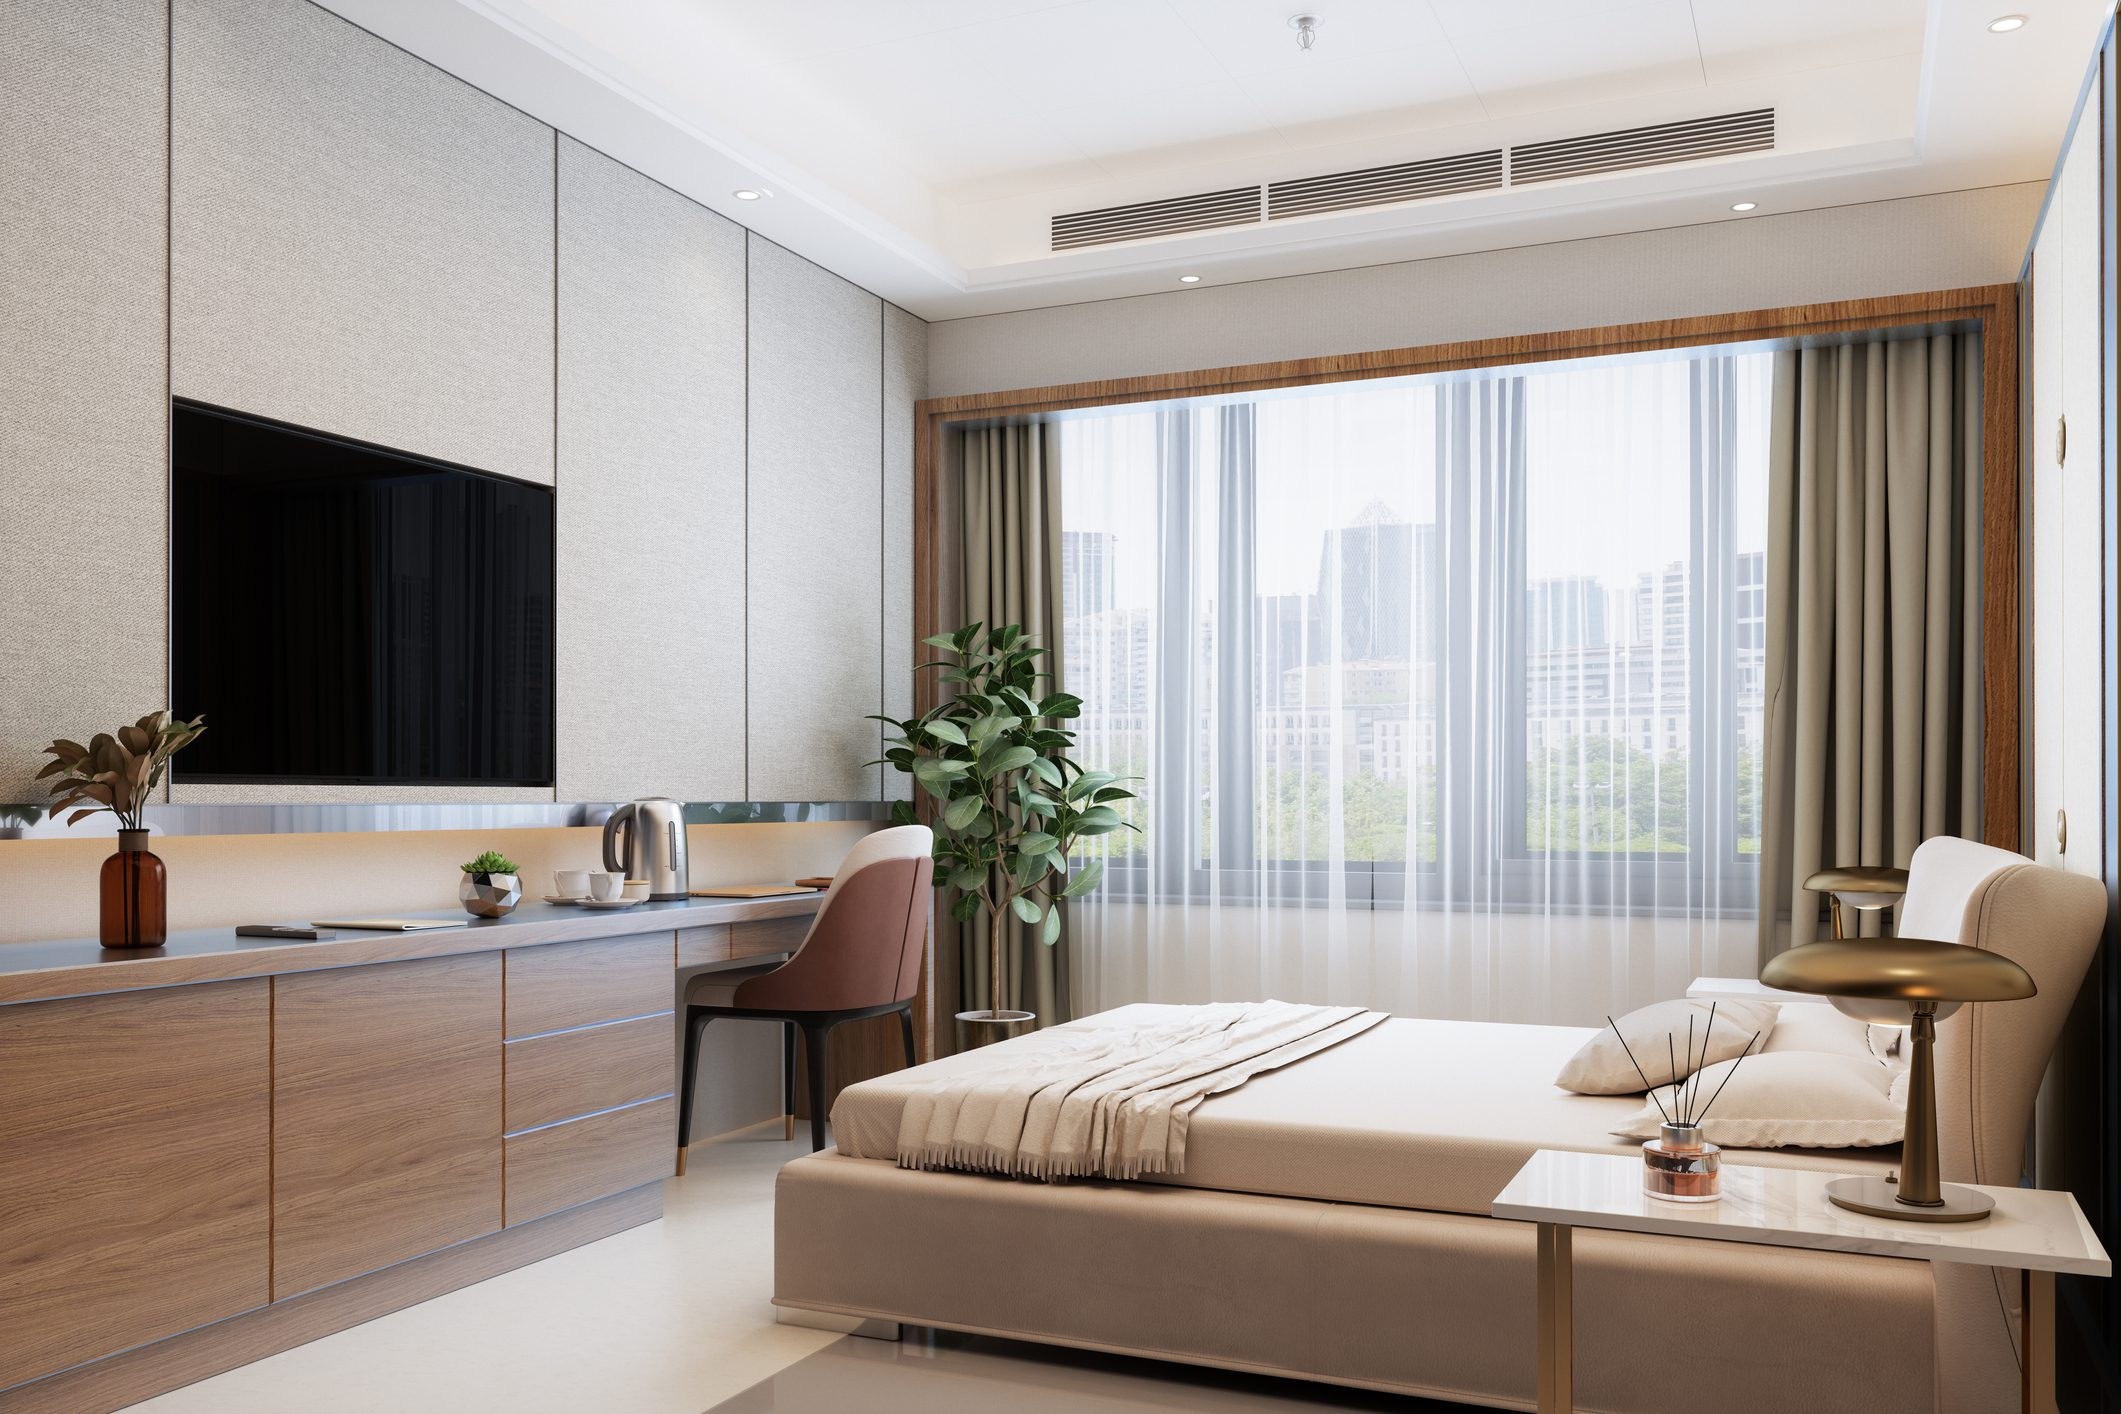

In [11]:
from PIL import Image

img = Image.open("image.jpg")
img

In [8]:
%%time

data = img2text("image.jpg", "Describe what is available in this image in full details")

CPU times: user 38.8 s, sys: 119 ms, total: 39 s
Wall time: 50.9 s


In [9]:
data

{'description': ' The image features a well-furnished bedroom with a large bed, a desk, and a television. The bed is positioned towards the right side of the room, while the desk is located closer to the left side. The television is placed on the left side of the room, providing entertainment options for the occupants.\n\nIn addition to the main furniture, there are several decorative elements in the room. A potted plant is placed near the center of the room, adding a touch of greenery. A vase can be found on the left side of the room, and a bottle is located on the right side. A chair is also present in the room, situated near the center. The room appears to be well-lit, with a window allowing natural light to enter.'}

## ChatBot Aggregation

In [12]:
from openai import OpenAI

In [14]:
def chatbot(message, description):

    model = "google/gemini-flash-1.5-exp"
    base_url = "https://openrouter.ai/api/v1"

    client = OpenAI(api_key = OPENROUTER_API_KEY, base_url=base_url)

    completion = client.chat.completions.create(
        model = model,
        messages = [{"role": "system", "content" : f"What you are given is the result of an image analysis AI. Your taks is to work on the input data like what the user asked. \nHere is the data: {description}"},
        {"role" : "user", "content" : f"{message}"}],
        temperature = 0.75,
        max_tokens = 2048
    )


    return completion.choices[0].message.content

## Testing Chatbot

In [16]:
chatbot("What can a young couple do in this room?", data['description'])

"Based on the image analysis, a young couple could enjoy a variety of activities in this well-furnished bedroom:\n\n* **Relax and unwind:** The large bed provides a comfortable space for relaxing, reading, or simply spending quality time together. \n* **Watch movies or TV:** The television on the left side of the room offers entertainment options for cozy evenings in.\n* **Work or study:** The desk provides a dedicated space for either partner to work on their laptop or study. \n* **Enjoy a quiet evening:** The potted plant and overall well-lit atmosphere creates a relaxing ambiance. They can enjoy a conversation, a glass of wine (from the bottle), or simply enjoy each other's company.\n* **Read or engage in hobbies:** The chair near the center could be used for reading, crafting, or any other hobby they enjoy.\n\nEssentially, this bedroom offers a versatile space for a young couple to both relax and be productive, fostering a comfortable and enjoyable living environment. \n"